Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.



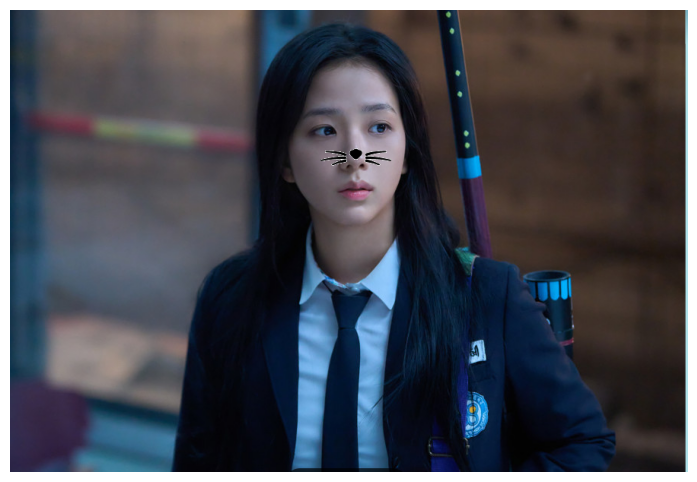

In [1]:
!pip install cmake
!pip install opencv-python
!conda install -y dlib

import os                               # 파일 경로 처리를 위한 모듈
import cv2                              # OpenCV: 이미지 읽기/처리용
import numpy as np                      # 수치 연산용 라이브러리
import dlib                             # 얼굴 검출·랜드마크 예측용
import matplotlib.pyplot as plt         # 결과 시각화를 위한 라이브러리

# ────────────────────────────────────────────────────────
# 0) 이미지 및 모델 초기화
#    • home_dir: 사용자 홈 디렉터리 (환경변수)
#    • img_bgr: OpenCV가 읽어들인 BGR 이미지
#    • img_rgb: dlib과 matplotlib용 RGB 이미지
#    • detector: dlib의 HOG 기반 얼굴 검출 모델
#    • dlib_rects: detector가 찾아낸 얼굴 영역 리스트
#    • predictor: 68개 랜드마크를 예측하는 dlib 모델
# ────────────────────────────────────────────────────────
home_dir   = os.getenv("HOME")
img_bgr    = cv2.imread(os.path.join(home_dir, "work/camera_sticker/images/test_img.png"))
img_rgb    = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
detector   = dlib.get_frontal_face_detector()  
dlib_rects = detector(img_rgb, 1)  # 1회 업샘플로 작은 얼굴도 검출
predictor  = dlib.shape_predictor(
    os.path.join(home_dir, "work/camera_sticker/models/shape_predictor_68_face_landmarks.dat")
)

# ────────────────────────────────────────────────────────
# 1) 수염 스티커 로드 & 배경 투명화
#    • IMREAD_UNCHANGED: PNG 알파 채널까지 불러옴
#    • 흰색(240~255) 픽셀만 골라 alpha=0 처리 → 투명 배경 생성
# ────────────────────────────────────────────────────────
sticker_path = os.path.join(home_dir, "work/camera_sticker/images/cat-whiskers.png")
img_sticker  = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED)

if img_sticker.shape[2] == 3:
    white_mask     = np.all(img_sticker[:, :, :3] >= 240, axis=2)
    alpha_channel  = np.where(white_mask, 0, 255).astype(np.uint8)
    img_sticker    = np.dstack((img_sticker, alpha_channel))

# ────────────────────────────────────────────────────────
# 2) 오버레이 설정값
#    • scale_ratio: 얼굴 폭 대비 스티커 너비 비율 (60%)
#    • offset_ratio: 얼굴 폭 대비 x축 추가 이동 비율 (10%)
# ────────────────────────────────────────────────────────
scale_ratio  = 0.6
offset_ratio = 0.0

# ────────────────────────────────────────────────────────
# 3) 얼굴별로 수염 합성
#    과정:
#     a) 랜드마크 #30 → 코 끝 좌표 추출
#     b) 얼굴 폭 → 스티커 크기 계산 & 리사이즈
#     c) 코 기준 중앙 정렬 + 오프셋 적용
#     d) 좌표 음수 보정(경계 밖 스티커 자르기)
#     e) alpha 채널 기반 블렌딩
#     f) 합성 결과를 img_bgr에 덮어쓰기
# ────────────────────────────────────────────────────────
for rect in dlib_rects:
    # a) 코 끝점 좌표
    lm      = predictor(img_rgb, rect)
    nose_x  = lm.part(30).x
    nose_y  = lm.part(30).y

    # b) 스티커 크기: 얼굴 폭 * scale_ratio
    face_w      = rect.width()
    target_w    = int(face_w * scale_ratio)
    target_h    = int(img_sticker.shape[0] * (target_w / img_sticker.shape[1]))
    sticker_res = cv2.resize(img_sticker, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # c) 중앙 정렬 후 x축으로 offset_ratio 만큼 추가 이동
    offset_px = int(face_w * offset_ratio)
    x0        = nose_x - target_w // 2 - offset_px
    y0        = nose_y - target_h // 2

    # d) 경계 처리: x0, y0가 음수면 스티커 잘라내기
    if x0 < 0:
        sticker_res = sticker_res[:, -x0:]
        x0 = 0
    if y0 < 0:
        sticker_res = sticker_res[-y0:, :]
        y0 = 0

    # e) ROI(원본 이미지에 덮을 영역) 추출
    roi = img_bgr[y0:y0+sticker_res.shape[0], x0:x0+sticker_res.shape[1]]

    #    alpha 채널 기반 블렌딩:
    #    • 투명(alpha=0) 픽셀은 원본 ROI 유지
    #    • 불투명 픽셀은 스티커 RGB로 덮기
    if sticker_res.shape[2] == 4:
        combined = np.where(
            sticker_res[:, :, 3:] == 0,
            roi,
            sticker_res[:, :, :3]
        ).astype(np.uint8)
    else:
        combined = sticker_res

    # f) 합성된 이미지를 원본에 다시 삽입
    img_bgr[y0:y0+combined.shape[0], x0:x0+combined.shape[1]] = combined

# ────────────────────────────────────────────────────────
# 4) 최종 결과 출력
#    • plt.title() 제거로 한글 폰트 경고 차단
#    • 축 숨기기
# ────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
